In [15]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style("white")
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [16]:
data_total = pd.read_csv('./ESL-data/ESLmixture.csv').iloc[:,1:]
data_total.head(n=5)

,X1,X2,label
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0
3,0.693436,0.777194,0
4,-0.019837,0.867254,0


In [17]:
px1 = pd.read_csv('./ESL-data/ESLpx1.csv').iloc[:,1]
px2 = pd.read_csv('./ESL-data/ESLpx2.csv').iloc[:,1]

In [18]:
prob = np.array(pd.read_csv('./ESL-data/ESLprob.csv').iloc[:,1].values).reshape(len(px2),len(px1))
prob_list = pd.read_csv('./ESL-data/ESLprob.csv').iloc[:,1]

* The following equation is given to compute the bayes error
$ bayes.error = sum(marginal*(prob*I(prob<0.5)+(1-prob)*I(prob>=.5))) $

In [19]:
marginal = pd.read_csv('./ESL-data/ESLmarginal.csv').iloc[:,1]

In [20]:
prob_list[prob_list >= .5] = 1 - prob_list[prob_list >= .5].values

In [21]:
bayes_error = np.sum(marginal*prob_list)
bayes_error

0.21011920330105552

In [22]:
data_total['fold'] = None
data_total['color'] = None
np.random.seed(123)
data_total['fold'] = np.random.randint(1, 11, size=(data_total.shape[0],1))

In [23]:
data_total.head(n=5)

,X1,X2,label,fold,color
0,2.526093,0.321050,0,3,None
1,0.366954,0.031462,0,3,None
2,0.768219,0.717486,0,7,None
3,0.693436,0.777194,0,2,None
4,-0.019837,0.867254,0,4,None


In [24]:
# define the svm classifer model
def svc_model(penalty):
    model = SVC(kernel='linear', C=penalty)
    model.fit(data_total.iloc[:,[0,1]], data_total['label'])
    return(model)

In [25]:
def check_boud(x1, x2, w, model, intercept, margin):
    y1 = w * x1 - intercept - margin
    y2 = w * x1 - intercept + margin
    if (np.abs(y1 - x2) < 0.01) or (np.abs(y2 - x2) < 0.003):
        return(x1, x2)
    else:
        return None

In [26]:
def plot_svc(model, ax=None):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    
    PX1, PX2 = np.meshgrid(px1, px2)

    # grid
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    grid_label = model.predict(xy)
    grids = np.hstack([xy, grid_label[:,np.newaxis]])
    grids = pd.DataFrame(grids)
    grids.columns = ['X1', 'X2', 'label']
    #boudary and margins
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1],
               alpha=0.8, linestyles=['--', '-', '--'])
    
    ax.contour(PX1, PX2, prob, levels=[.5],
            colors='purple', linestyles='--', alpha = 0.9)
    beta = model.coef_[0]
    w = -beta[0] / beta[1]
    xx = np.linspace(xlim[0], xlim[1])
    intercept = model.intercept_ / beta[1]

    # compute the margin
    margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
    margin = np.sqrt(1 + w ** 2) * margin
    
    for i in np.arange(data_total.shape[0]):
        tst = check_boud(data_total.iloc[i,0], data_total.iloc[i,1], w, model,
                  intercept, margin)
        if tst is not None:
            x1, x2 = tst
            ax.scatter(x1, x2, c='k', s=30)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim((np.min(px1)-0.1, np.max(px1)+0.1))
    ax.set_ylim((np.min(px2)-0.1, np.max(px2)+0.1))
    ax.annotate('Bayes Error  :  {:.2f}'.format(bayes_error), ha='right', va='top',
                xy=(0.2, 0.), xycoords="axes fraction",
                bbox=dict(boxstyle='round', fc='w'), size=12)
    return(grids,w,intercept)

Text(0.5, 0, 'C = 10000')

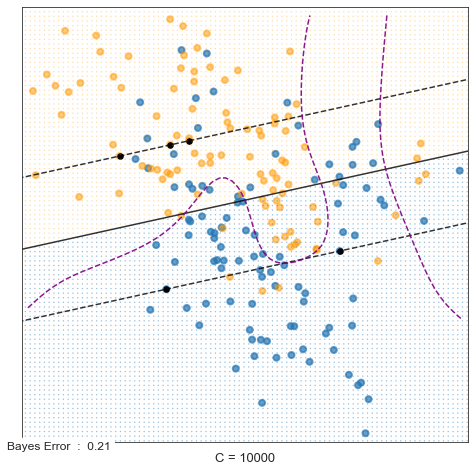

In [13]:
# sns.scatterplot(x=data_total['X1'], y=data_total['X2'], s=60,
#                 hue=data_total['label'], marker='o')
plt.figure(figsize=(8,8))
model1 = svc_model(0.6)
colors = [(0.1500, 0.4667, 0.7059, 0.7), 
          (1.000, 0.6, 0.002, 0.5)]
cmap = ListedColormap(colors)
plt.scatter(x="X1", y="X2", c="label", data=data_total, cmap=cmap, linewidth=2)
grids,w,intercept = plot_svc(model1)
plt.scatter(x="X1", y='X2', c=grids.iloc[:,2], data=grids, cmap=cmap, s=0.1)
plt.xlabel('C = 10000', fontsize=13)

In [14]:
w

0.16461237693235167

Text(0.5, 0, 'C = 0.01')

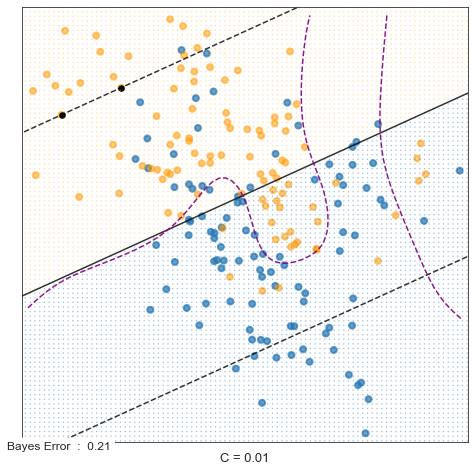

In [28]:
plt.figure(figsize=(8,8))
model1 = svc_model(1e-2)
colors = [(0.1500, 0.4667, 0.7059, 0.7), 
          (1.000, 0.6, 0.002, 0.5)]
cmap = ListedColormap(colors)
plt.scatter(x="X1", y="X2", c="label", data=data_total, cmap=cmap, linewidth=2)
grids,w,intercept = plot_svc(model1)
plt.scatter(x="X1", y='X2', c=grids.iloc[:,2], data=grids, cmap=cmap, s=0.1)
plt.xlabel('C = 0.01', fontsize=13)

In [30]:
intercept

array([-0.52575836])

In [31]:
w

0.34038130417300716